In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from pprint import pprint as pprint
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import Table, DropTable
import pandas as pd

In [4]:
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [5]:
# All distinct users

distinctUsers = pd.read_sql_query('SELECT user_id FROM user', engine)
print(len(distinctUsers))

42232


In [6]:
# Users whose posts had been retweeted

authorsOfRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfRetweetedPosts))

2827


In [7]:
# Users whose posts had never been retweeted

authorsOfNonRetweetedPosts = pd.read_sql_query(
                          'SELECT user1.user_name AS user \
                           FROM user AS user1 \
                           WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id)', engine)
print(len(authorsOfNonRetweetedPosts))

39405


In [8]:
# Users who had retweeted posts of other users

retweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(retweetingUsers))

35425


In [9]:
# Users who had never retweeted posts of other users

nonRetweetingUsers = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(nonRetweetingUsers))

6807


In [10]:
# Users whose posts had never been retweeted NEITHER had they retweeted posts of other users

doubleNonRetweeters = pd.read_sql_query(
                            'SELECT user1.user_name AS user \
                             FROM user AS user1 \
                             WHERE user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN tweet ON tweet.user_id = user2.user_id \
                                  INNER JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id ) \
                            AND user1.user_id NOT IN \
                                 (SELECT user2.user_id \
                                  FROM user AS user2 \
                                  INNER JOIN retweet ON retweet.user_id = user2.user_id )', engine)
print(len(doubleNonRetweeters))

4962


In [145]:
userPairs = pd.read_sql_query('SELECT user1.user_name AS user, COUNT(*) as number_of_retweets, \
                            user2.user_name AS retwitter \
                            FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user1.user_id \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = user2.user_id \
                             WHERE retwitter IS NOT NULL \
                             GROUP BY user, retwitter', engine)
print(len(userPairs))

67833


In [146]:
# file = open('userpairs.txt','w') 

# file.write('user,retwitter,number_of_retweets\n')
# for index, row in userPairs.iterrows():
#     file.write(str(row['user']) + ',' + str(row['retwitter']) + ',' + str(row['number_of_retweets']) + '\n') 
# file.close() 

In [161]:
G = nx.from_pandas_edgelist(userPairs, 'user', 'retwitter', edge_attr='number_of_retweets')
pprint(nx.info(G))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 35200\n'
 'Number of edges: 67621\n'
 'Average degree:   3.8421')


In [162]:
# Get nodes with degree >= min_degree

min_degree = 7
nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [163]:
# Create a subgraph with nodes degree >= min_degree (in the G graph)

G_sampled = G.subgraph(nodes)
pprint(nx.info(G_sampled))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 1988\n'
 'Number of edges: 14901\n'
 'Average degree:  14.9909')


In [164]:
# file = open('userpairs.csv','w') 

# file.write('user,retwitter,number_of_retweets\n')
# for index, row in userPairs.iterrows():
#     if G_sampled.has_edge(row['user'], row['retwitter']):
#         file.write(str(row['user']) + ',' + str(row['retwitter']) + '\n') 
# file.close() 

In [165]:
def get_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

In [166]:
# nx.draw(G_sampled, with_labels=False, edges=G_sampled.edges)
# plt.show()

In [167]:
print("users", len(G_sampled.nodes))
print("connections",len(G_sampled.edges))

users 1988
connections 14901


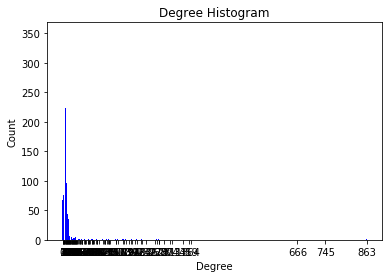

In [168]:
# avg_node_connectivity = nx.networkx.average_node_connectivity(G)
# print('Average node connectivity: ', avg_node_connectivity)

get_histogram(G_sampled)

In [169]:
from networkx.algorithms.community.centrality import girvan_newman
communities_iter = girvan_newman(G_sampled)

communities_sum = 0
communities_gn = []

for community_gn in next(communities_iter):
    communities_sum += 1
    communities_gn.append(community_gn)
    print("Community ", communities_sum)
    print(community_gn)
    print("Liczno≈õƒá community: ", len(community_gn), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
{'JB (#MAGA)', 'Rex Myers 45‚≠ê‚≠ê‚≠ê‚ùå', 'Justice Time', 'Steel', 'Richard', '‚ùåPowerglobal‚ùå', '‚ùå Pat WestcQtt  ‚ùå', 'Kathleen Donovan', 'Cindyseestruth', 'Ginger Murray', 'Cindi', 'üëâIma Nationalist/In The End We winüëà', '‚ùåTTüöÇ jazz ‚ùå', 'SNARKY by Nature‚òùüá∫üá∏  üñï Cancer', 'ùìõùì≤ùìºùì™ üá∫üá∏‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Jennifer üî±üá∫üá∏üî±üåüüåüüåü', 'üá∫üá∏GENESISüá∫üá∏üåüüåüüåü', 'üá∫üá∏ KO Conservative Republican üá∫üá∏', 'GS', 'Robert Infanti', 'SmartDissent.com', 'Trump Force 2020 üá∫üá∏', 'ProudNavyVeteran üá∫üá∏‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏èüá∫üá∏', 'Washington News Line', 'Layla {‚≠ê}', 'leela rose', 'üåüTinTXüí´#CruzCrew #Trump #KAGüá∫üá∏', 'beverly j garvey', 'üå∏üå∏Janet Willisüå∏üå∏', 'Arie #1@Arie Brawley', 'America MUST Unite ‚öñÔ∏èüá∫üá∏', 'Elbert C. Lyon', 'Cowdog  üá∫üá∏üóΩüá∫üá∏', 'üöÇüá∫üá∏NATIONALIST MAGA SHEILAüá∫üá∏üöÇ‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Charlie D üïä', 'üêòüá∫üá∏ Kim üá∫üá∏üêò', 'j

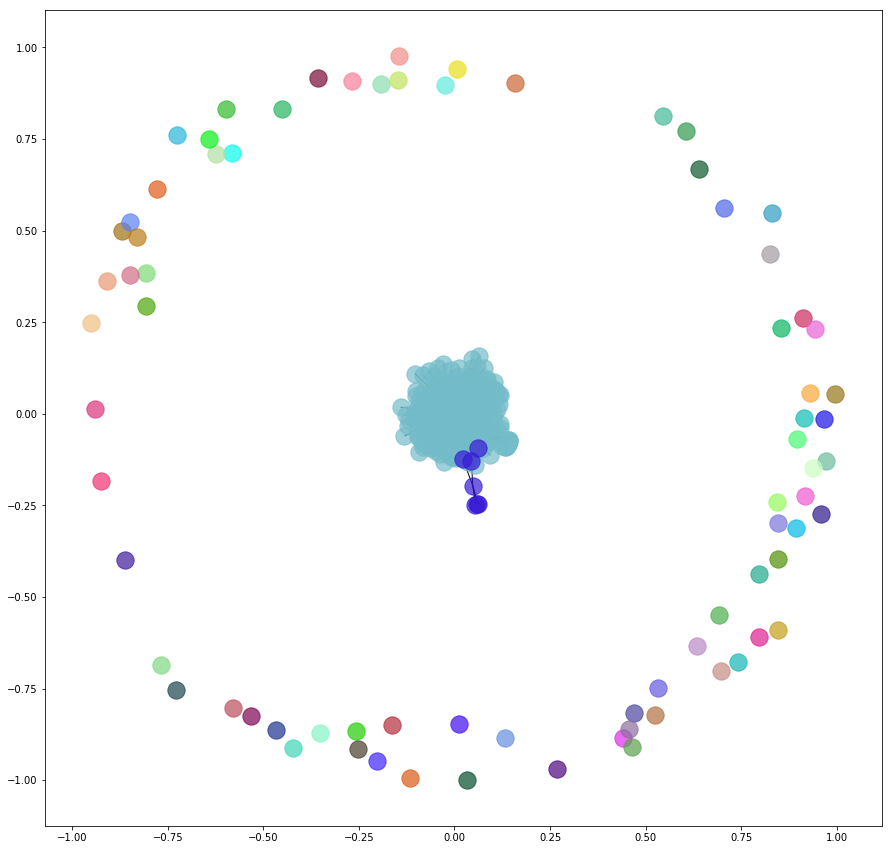

In [170]:
from matplotlib.pyplot import figure
import numpy

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in list(communities_gn):
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [171]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
communities_gmc = greedy_modularity_communities(G_sampled)

communities_sum = 0

for community_gmc in communities_gmc:
    communities_sum += 1
    print("Community ", communities_sum)
    print(community_gmc)
    print("Liczno≈õƒá community: ", len(community_gmc), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
frozenset({'JamieR {üéó} Army Girl', 'Patriot Gary', 'üá∫üá∏Meggsüå¥üá∫üá∏üá∫üá∏üá∫üá∏üá∫üá∏', 'NATIONALIST CKB', '3 People Like This', 'Mac', 'Deplorable Me, Büåüüåüüåü', 'Richard', 'Sandi Pirie‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Doc Rock ‚ùå', 'Kathleen Donovan', 'Cathy ski', 'Cindi', 'colliertimothy8@gmail.com', 'üá∫üá∏Kimberleeüá∫üá∏‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Jeremy (on Politics)', 'Theresa', 'Scott', 'Christine', 'üá∫üá∏GENESISüá∫üá∏üåüüåüüåü', 'Mike', 'ACT for America', 'LOOMER', 'james cabbage', 'Trendy Elephant', 'Robert Infanti', 'BibleBeltMomma‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Washington News Line', 'Rick', 'Toddmarshock #MAGAüá∫üá∏üá∫üá∏üá∫üá∏', 'MD DD', 'üá∫üá∏', 'üå∏üå∏Janet Willisüå∏üå∏', 'Brandon B', 'America MUST Unite ‚öñÔ∏èüá∫üá∏', 'bill a bong‚≠ê‚≠ê‚≠ê', 'Leon', 'K Witt\U0001f929üèñÔ∏è', 'Debbie', 'Gracie Nunyabiz', 'Tamara üòé', 'Dan Olney üá∫üá∏ ‚ùå‚ùå‚ùå‚ùå', 'Missgraciemae üåπ', 'Deplorable Reagan‚ùåNationalist !', 'Nationalist Nora', '

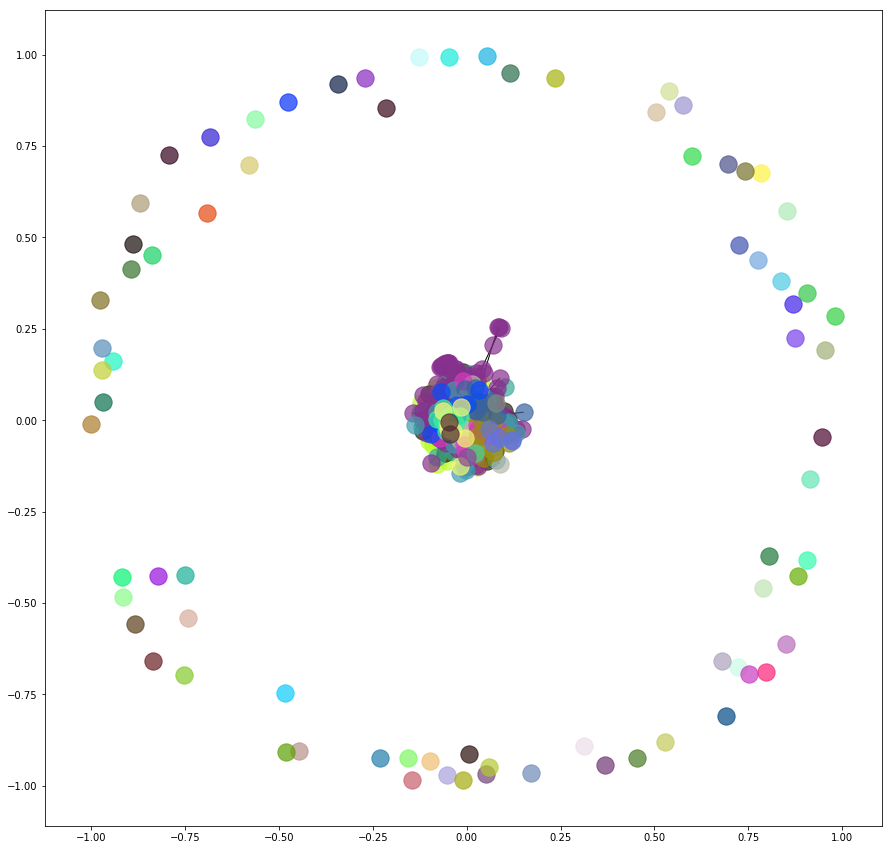

In [172]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in communities_gmc:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [173]:
sorted(G_sampled.degree, key=lambda x: x[1], reverse=True)[:10]


[('Patriot Gary', 863),
 ('TheKat ‚ù§Ô∏è', 745),
 ('Cody', 666),
 ('Jennifer üî±üá∫üá∏üî±üåüüåüüåü', 364),
 ('fordnFLA777 (K)‚ô•Ô∏è‚úùÔ∏è ‚ù§Ô∏è‚ú°Ô∏è', 359),
 ('Chris  üá∫üá∏ Let Freedom Ring', 341),
 ('ü¶Ö ü¶Ö Nationalist Eagle ü¶Öü¶Ö', 311),
 ('üá∫üá∏üî•Lady De‚ÄôPlorableüî•üá∫üá∏', 304),
 ('üá∫üá∏ SKY45 üá∫üá∏ Ô∏ª„Éá‚ïê‰∏Ä', 287),
 ('üêòüá∫üá∏ Kim üá∫üá∏üêò', 273)]

In [174]:
degree_centrality = sorted(nx.degree_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [175]:
degree_centrality[:10]

[('Patriot Gary', 0.43432310015098136),
 ('TheKat ‚ù§Ô∏è', 0.3749370910920986),
 ('Cody', 0.3351786612984399),
 ('Jennifer üî±üá∫üá∏üî±üåüüåüüåü', 0.1831907398087569),
 ('fordnFLA777 (K)‚ô•Ô∏è‚úùÔ∏è ‚ù§Ô∏è‚ú°Ô∏è', 0.18067438349270257),
 ('Chris  üá∫üá∏ Let Freedom Ring', 0.1716155007549069),
 ('ü¶Ö ü¶Ö Nationalist Eagle ü¶Öü¶Ö', 0.15651736285858078),
 ('üá∫üá∏üî•Lady De‚ÄôPlorableüî•üá∫üá∏', 0.15299446401610467),
 ('üá∫üá∏ SKY45 üá∫üá∏ Ô∏ª„Éá‚ïê‰∏Ä', 0.14443885254151986),
 ('üêòüá∫üá∏ Kim üá∫üá∏üêò', 0.1373930548565677)]

In [176]:
betweenness_centrality = sorted(nx.betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [177]:
betweenness_centrality[:10]

[('Patriot Gary', 0.19181441394888327),
 ('TheKat ‚ù§Ô∏è', 0.13659055470928877),
 ('Cody', 0.11275642551425281),
 ('fordnFLA777 (K)‚ô•Ô∏è‚úùÔ∏è ‚ù§Ô∏è‚ú°Ô∏è', 0.03590117458537037),
 ('Chris  üá∫üá∏ Let Freedom Ring', 0.03206624946604979),
 ('Jennifer üî±üá∫üá∏üî±üåüüåüüåü', 0.03196283507955331),
 ('üá∫üá∏üî•Lady De‚ÄôPlorableüî•üá∫üá∏', 0.0279184298565226),
 ('ü¶Ö ü¶Ö Nationalist Eagle ü¶Öü¶Ö', 0.023745281142439997),
 ('Laura Vote Red', 0.021254276462776965),
 ('üá∫üá∏ SKY45 üá∫üá∏ Ô∏ª„Éá‚ïê‰∏Ä', 0.02079763981219131)]

In [178]:
edge_betweenness_centrality = sorted(nx.edge_betweenness_centrality(G_sampled).items(), key=lambda x: x[1], reverse=True)

In [179]:
edge_betweenness_centrality[:10]

[(('Matthew', 'PoliBot'), 0.007236467581354899),
 (('Jon McNaughton', 'Mike'), 0.0038135405641255217),
 (('Loomered‚ù§Ô∏èMolly‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'PoliBot'), 0.003681704272266915),
 (('Patriot Gary', 'Cody'), 0.003307055057079051),
 (('Save USA vote red ‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è  üöÇüí®üá∫üá∏', 'Cody'), 0.003184413892094193),
 (('Votez Poisson ‚úùÔ∏è', 'Jon McNaughton'), 0.0028527747506317583),
 (('Matthew', 'TheKat ‚ù§Ô∏è'), 0.0026148341881083764),
 (('Chris  üá∫üá∏ Let Freedom Ring', 'Patriot Gary'), 0.0025317852051441577),
 (('Matthew', 'Patriot Gary'), 0.002335774514507763),
 (('Str8 Don Lemonüçãüë´üç∫üåà‚ù§', 'Cody'), 0.002230115309342299)]

In [180]:
from networkx.algorithms.community import k_clique_communities
cliques = list(k_clique_communities(G_sampled, 6))

In [181]:
for clique in cliques:
    print(len(clique))
    print(clique)

148
frozenset({'JamieR {üéó} Army Girl', 'Patriot Gary', 'Sektor (K)', 'üë†IStandWithTrump‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', '#MAGA MICHELLE VOTING RED TO SAVE AMERICA üî¥üî¥', 'Bill', 'Jo4Trump {‚≠êÔ∏è} (K) ‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'KayakSandyüê∏', 'JCsPatricia', 'Linda', 'üá∫üá∏The Real Catia üáÆüáπ', 'TheChristiansNewSheriffInTown', 'ü•ÄüïäSassüïäü•ÄSuper Elite Deplorableü•Ä', 'Jenny I Voted Red2018', 'ALS1963üñ§üá∫üá∏', '‚ùåPowerglobal‚ùå', 'Currentflow', 'Ôº§ÔΩÅÔΩíÔΩãÔºßÔΩíÔΩÖÔΩôÔºßÔΩàÔΩèÔΩìÔΩîüåπ-K-', "üá∫üá∏'Super Elite Texan'üá∫üá∏    ‚ñÑÔ∏ªÃ∑Ãø‚îªÃø‚ïê‚îÅ‰∏Ä", 'üï∞‚ö°Ô∏èEinstein MAGAüí°üéô', 'üá∫üá∏ Miguelifornia', 'RuthieRedSox', 'Elle Hartüåüüåüüåü American Nationalist', 'I ‚ù§Ô∏è Winning üá∫üá∏‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏èüë†{‚≠êÔ∏è}#ProudNationalist', 'Testy~Nationalist~Tarheel ‚Ñ¢Ô∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 'Cindyseestruth', 'Patriot Harley', 'Carol', 'üá∫üá∏Nationalist Loriüá∫üá∏ #WWG1WGA', 'Dawn Orlando', 'üá∫üá∏ üçµ Johnny B üçµ üá∫üá∏', '~MaryEllen~ (K)', 'J

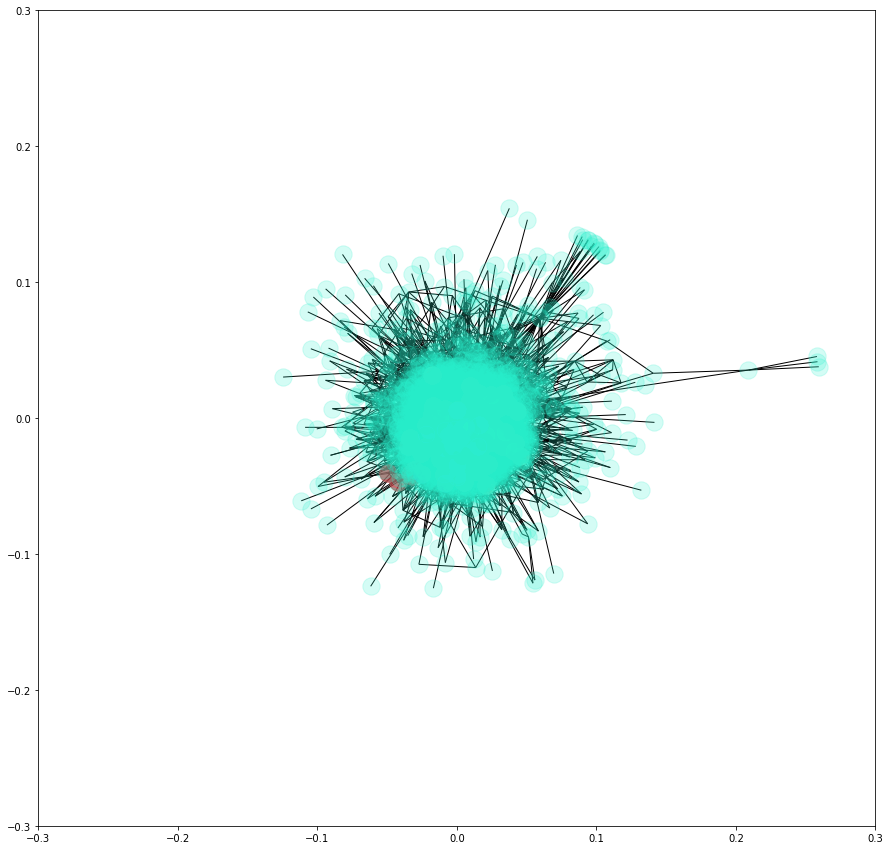

In [186]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for clique in cliques:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=clique,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=G_sampled.nodes,
                           node_color=numpy.random.rand(3,),
                           alpha=0.2)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)

plt.show()

In [183]:
# active users in distinct cliques

distinct_users_in_cliques = {}

for clique in cliques:
    for user in clique:
        if user in distinct_users_in_cliques:
            distinct_users_in_cliques[user] += 1
        else:
            distinct_users_in_cliques[user] = 1

In [184]:
top_users_in_cliques = sorted(distinct_users_in_cliques.items(), key=lambda x : x[1], reverse=True)
top_users_in_cliques[:5]

[('üë†IStandWithTrump‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', 3),
 ('@gary[WontBackDown]', 3),
 ('üá∫üá∏  Consmover üá∫üá∏', 3),
 ('Patriot Gary', 2),
 ('Sektor (K)', 2)]

In [185]:
### Get Vader for this users
user = top_users_in_cliques[10]
users = pd.read_sql_query('SELECT user.user_id AS id, user.user_name, tweet.tweet_id, vader.compound as vader_mood \
                            FROM user \
                             JOIN tweet ON tweet.user_id = user.user_id \
                             JOIN vader ON tweet.tweet_id = vader.id \
                             WHERE user.user_name = "' + user[0] + '"', engine)
users

Empty DataFrame
Columns: [id, user_name, tweet_id, vader_mood]
Index: []